# WSI 2022L
# Laboratorium 3/4 (Algorytm Genetyczny)
# Michał Brus, 299106

# Importy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Funkcja zysku (z zadania z rakietą)

In [2]:
def profit_function(engine_on_off_vector):
    height = 0
    velocity = 0
    fuel_units_mass = engine_on_off_vector.sum()  # vector consists of 1s and 0s so naturally the sum is a number of 1s
    total_mass = 20 + fuel_units_mass
    for t in range(len(engine_on_off_vector)):
        if engine_on_off_vector[t] == 1:
            engine_acceleration = 500 / total_mass
            total_mass = total_mass - 1
        else:
            engine_acceleration = 0
        friction_acceleration = -0.06 * velocity * abs(velocity) / total_mass
        gravity_acceleration = -0.9
        acceleration = engine_acceleration + friction_acceleration + gravity_acceleration
        velocity = velocity + acceleration  # v = v + a*t but t here is 1 time unit every time, so v = v + a
        height = height + velocity + acceleration / 2  # s = s + v*t + 0.5*a*t^2 but t here is 1 time unit every time,
        # so s = s + v + a/2
    if height >= 750:
        return 200 - fuel_units_mass
    else:
        return 0

# Inicjalizacja populacji początkowej

In [3]:
def initialise_population(population_size):
    bits_number = 200
    population = np.empty([population_size, bits_number])
    rng = np.random.default_rng()
    for i in range(population_size):
        population[i] = rng.integers(2, size=bits_number)
    return population

# Ocena jakości danej populacji

In [4]:
def evaluate(population, q_function):
    evaluation = np.empty([population.shape[0]])
    for i in range(len(evaluation)):
        evaluation[i] = q_function(population[i])
    return evaluation

# Selekcja ruletkowa

In [5]:
def roulette_selection(population, evaluation):
    population_size = population.shape[0]
    selection_probability = np.empty([population_size])
    for i in range(len(selection_probability)):
        selection_probability[i] = evaluation[i] / evaluation.sum()
    rng = np.random.default_rng()
    selected = rng.choice(population, population_size, p=selection_probability)  # should it be possible
    # for an individual to be selected more than once? Yes, otherwise everyone would be selected
    return selected

# Krzyżowanie jednopunktowe

In [6]:
def crossover(parent1, parent2, p_crossover):
    rng = np.random.default_rng()
    probability = rng.uniform(0, 1)
    if probability < p_crossover:
        cross_point = rng.integers(200).astype(int)
        child1 = np.concatenate((parent1[:cross_point], parent2[cross_point:]))
        child2 = np.concatenate((parent2[:cross_point], parent1[cross_point:]))
        return child1, child2
    else:
        return parent1, parent2

# Mutacja

In [7]:
def mutate(individual, p_mutation):
    genes_number = len(individual)
    rng = np.random.default_rng()
    p_genes_mutation = rng.uniform(0, 1, size=genes_number)
    for i in range(genes_number):
        if p_genes_mutation[i] < p_mutation:
            individual[i] = 1 if individual[i] == 0 else 0
    return individual

# Reprodukcja (krzyżowanie i mutacja)

In [8]:
def reproduce(p_crossover, p_mutation, selected):
    bits_number = 200
    population_size = selected.shape[0]
    new_population = np.empty([population_size, bits_number])
    for i in range(0, population_size-1, 2):
        parent1, parent2 = selected[i], selected[i + 1]
        child1, child2 = crossover(parent1, parent2, p_crossover)
        child1, child2 = mutate(child1, p_mutation), mutate(child2, p_mutation)
        new_population[i], new_population[i + 1] = child1, child2
        odd_individual = mutate(selected[-1], p_mutation)
        new_population[-1] = odd_individual  # if odd number of parents the last individual mutates and goes to new_pop
    return new_population

# Znalezienie najlepszego kandydata po ocenie populacji

In [9]:
def find_best(evaluation, population):
    index = evaluation.argmax()
    best_value = evaluation[index]
    return best_value, population[index]

# Algorytm genetyczny (wraz z zapisem historii działania)

In [10]:
def genetic_algorithm(q_function, p_mutation, p_crossover, population_size, population_budget):
    gen_max = int(population_budget / population_size)  # population budget and size determine the number of generations
    gen = 0
    population = initialise_population(population_size)
    evaluation = evaluate(population, q_function)
    best_yet = find_best(evaluation, population)
    best_values_history = np.array([best_yet[0]])
    best_points_history = np.array([best_yet[1]])
    generation_mean = evaluation.sum() / len(evaluation)
    generation_mean_history = np.array([generation_mean])
    while gen < gen_max-1:
        selected = roulette_selection(population, evaluation)
        offspring = reproduce(p_crossover, p_mutation, selected)  # crossover and mutation
        evaluation = evaluate(offspring, q_function)
        best = find_best(evaluation, population)
        best_values_history = np.concatenate((best_values_history, [best[0]]))
        best_points_history = np.concatenate((best_points_history, [best[1]]))
        generation_mean = evaluation.sum() / len(evaluation)
        generation_mean_history = np.concatenate((generation_mean_history, np.array([generation_mean])))
        if best_yet[0] < best[0]:
            best_yet = best
        population = offspring
        gen = gen + 1
    return best_yet, best_values_history, best_points_history, generation_mean_history

# Parametry domyślne

In [11]:
parameters_number = 5
iterations_number = 25
total_budget = 10**5

default_ps = 250
default_pm = 0.05
default_pc = 0.75

# Testowane parametry

In [16]:
populations = np.array([50, 100, 250, 500, 1000])
p_mutations = np.array([0.2, 0.1, 0.05, 0.01, 0.005])
p_crossovers = np.array([0.9, 0.75, 0.6, 0.5, 0.25])

# Funkcja testująca

In [13]:
def test(p_type, parameters, iterations):
    mean_best_values, mean_gen_means = compute_means(p_type, parameters, iterations)
    plot_means(mean_best_values, mean_gen_means, p_type, parameters)


def plot_means(mean_best_values, mean_gen_means, p_type, parameters):
    parameters_number = len(parameters)
    print("Średnia z najlepszych wyników:")
    for k in range(parameters_number):
        print(f"{p_type}: {parameters[k]}, optimum: {mean_best_values[k]}")
        y = np.array([mean_gen_means[k]])
        x = np.arange(len(mean_gen_means[k]))
        plt.figure(figsize=(20, 10))
        plt.scatter(x, y)
        plt.title("Wartość średnia funkcji w danej generacji")
        plt.xlabel("Generacje")
        plt.ylabel("E(q(x)")
        plt.grid(b=True)
        plt.show()


def compute_means(p_type, parameters, iterations):
    parameters_number = len(parameters)
    mean_best_values = np.empty(parameters_number)
    mean_gen_means = np.empty(parameters_number, dtype=object)
    for i in range(parameters_number):
        if p_type == "ps":
            number_of_gen = int(total_budget / parameters[i])
        else:
            number_of_gen = int(total_budget / default_ps)
        best_values = np.empty(iterations)
        gen_means = np.empty([iterations, number_of_gen])
        for j in range(iterations):
            if p_type == "ps":
                result = genetic_algorithm(profit_function, default_pm, default_pc, parameters[i], total_budget)
            elif p_type == "pm":
                result = genetic_algorithm(profit_function, parameters[i], default_pc, default_ps, total_budget)
            else:
                result = genetic_algorithm(profit_function, default_pm, parameters[i], default_ps, total_budget)
            best_values[j] = result[0][0]
            gen_means[j] = result[3]
        mean_best_values[i] = best_values.sum() / iterations
        mean_gen_means[i] = gen_means.sum(axis=0) / iterations
    return mean_best_values, mean_gen_means

# Badanie wpływu rozmiaru populacji na działanie AG

Średnia z najlepszych wyników:
ps: 50, optimum: 133.0


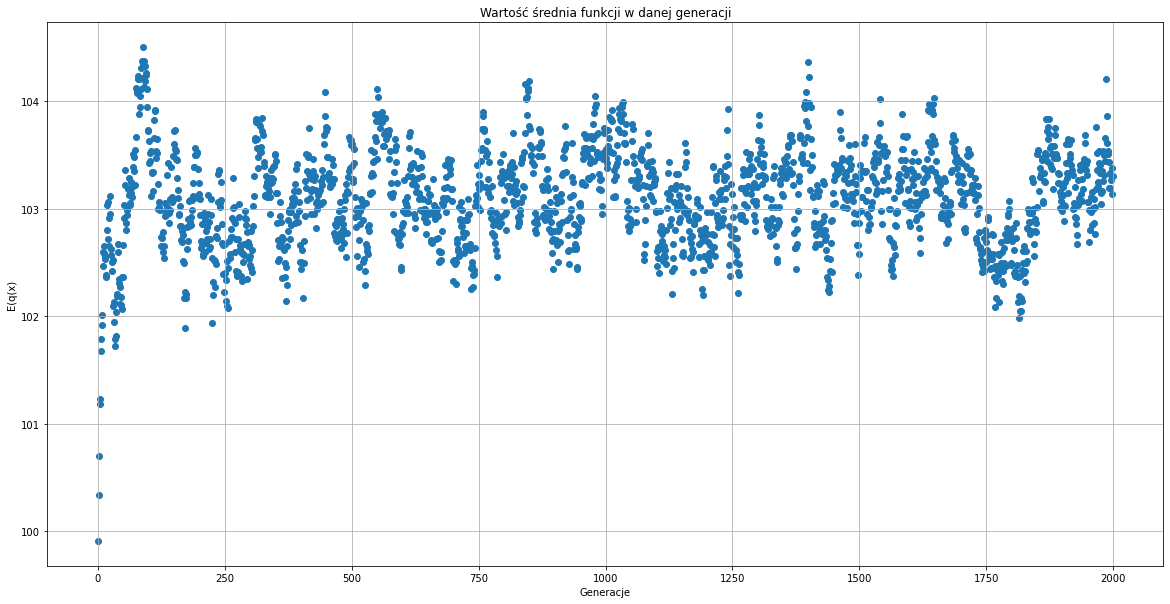

ps: 100, optimum: 133.88


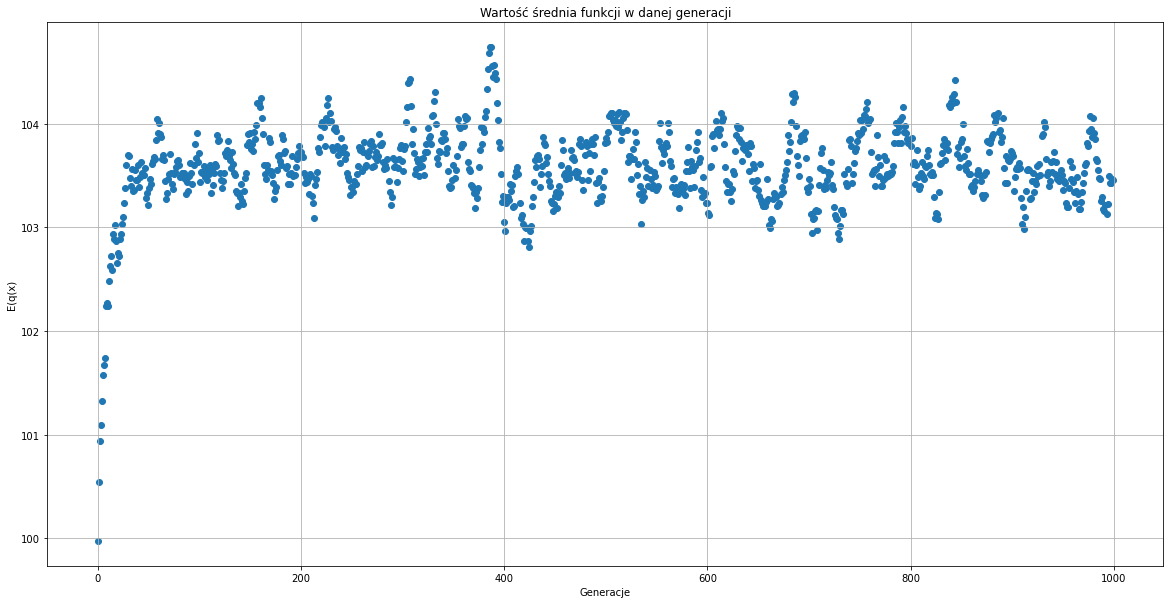

ps: 250, optimum: 134.36


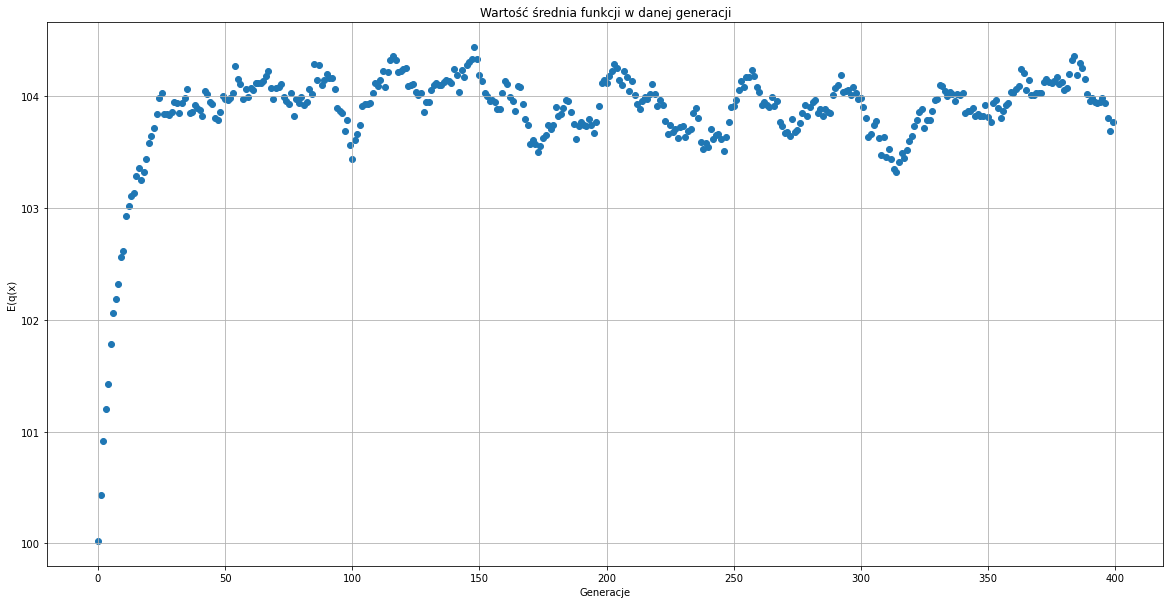

ps: 500, optimum: 133.84


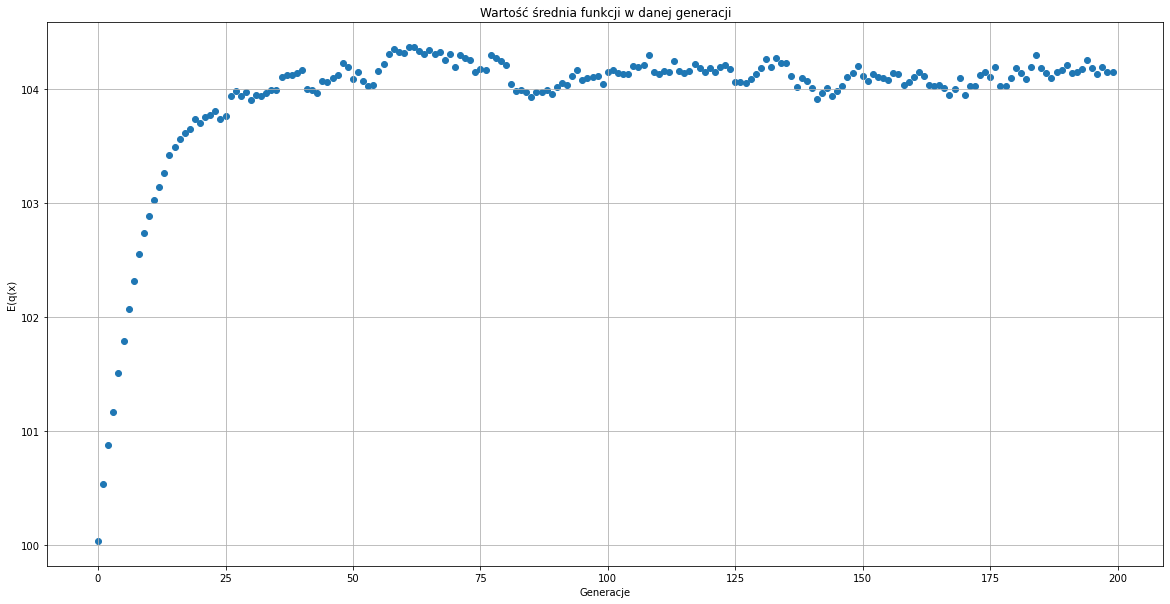

ps: 1000, optimum: 134.2


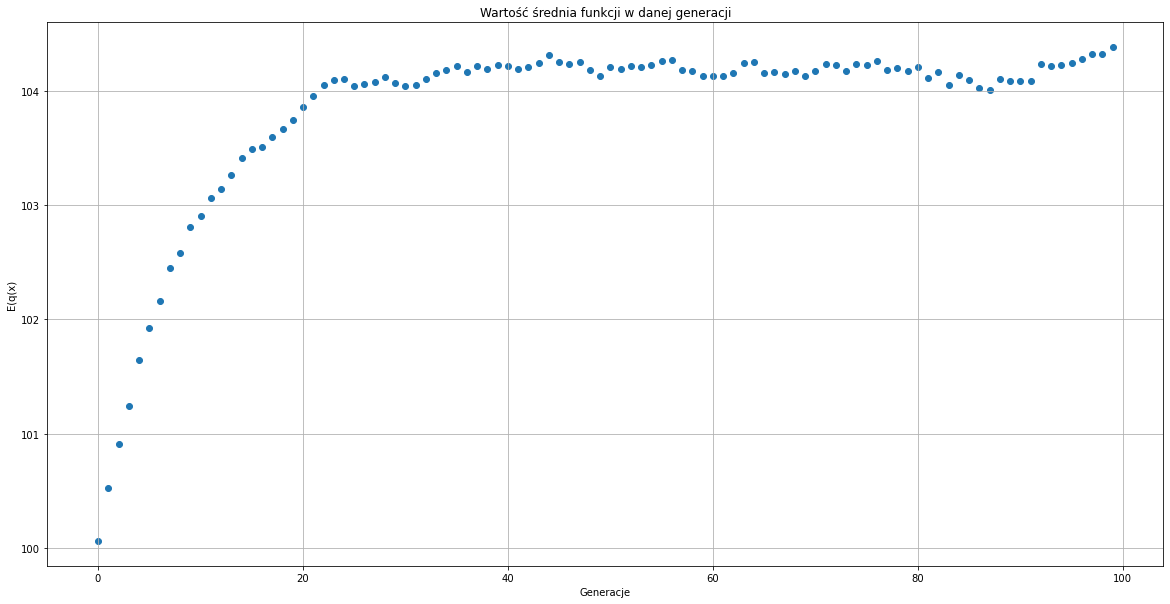

In [17]:
test("ps", populations, 25)

Im większa populacja, tym potencjalnie szybsze działanie, gdyż któryś z jej osobników losowo znajdzie się bliżej jakiegoś optimum funkcji. Natomiast im więcej osobników w populacji, tym również dłużej zajmuje jej optymalizacja. W praktyce tylko część rozwiązań okazuje się być optymalna, podczas gdy reszta zostaje wylosowana w słabych jakościowo miejscach.

# Badanie wpływu prawdopodobieństwa mutacji na działanie AG

Średnia z najlepszych wyników:
pm: 0.2, optimum: 131.48


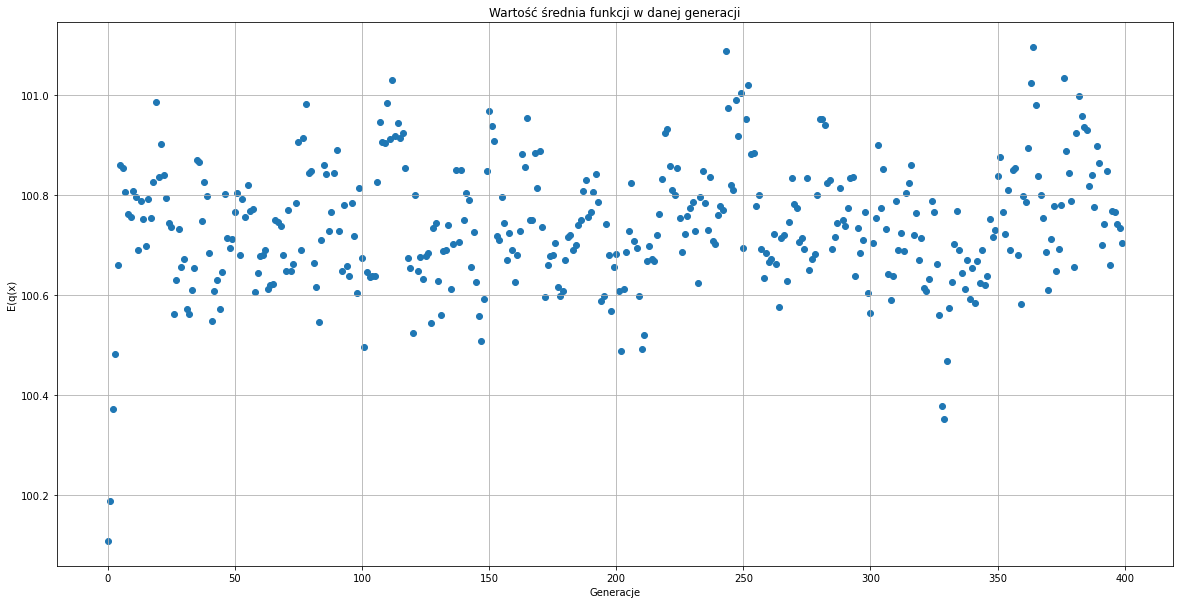

pm: 0.1, optimum: 132.72


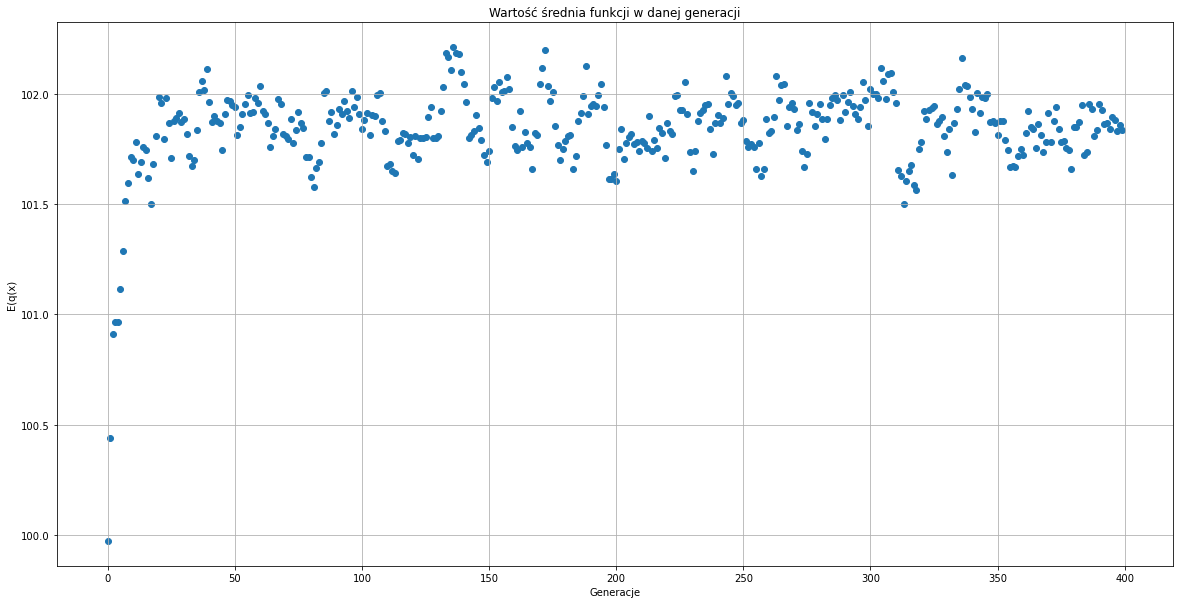

pm: 0.05, optimum: 134.16


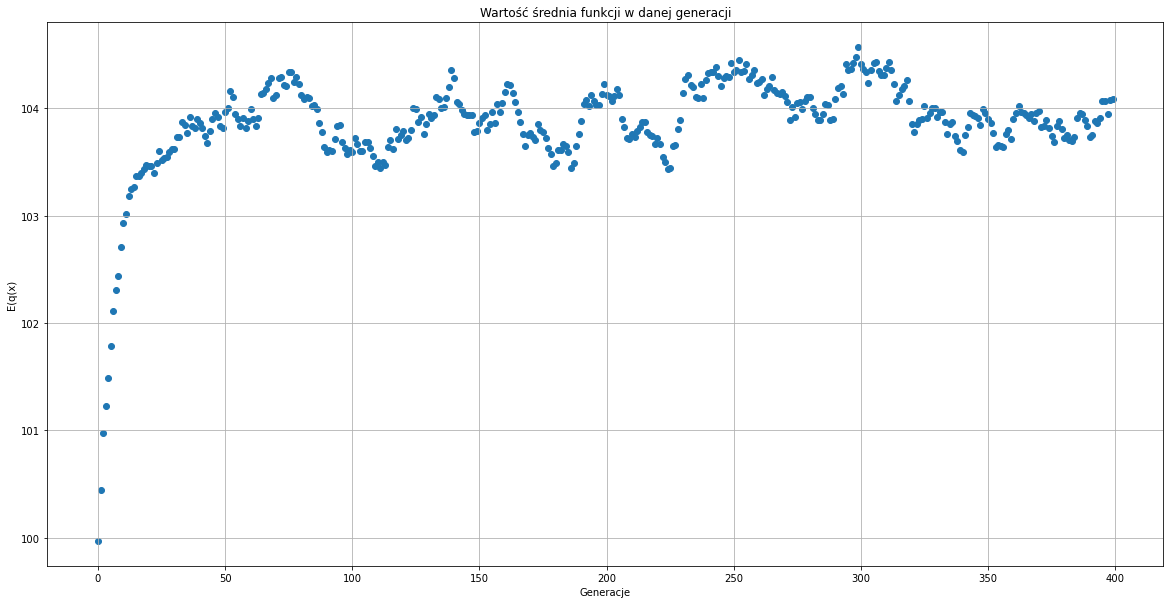

pm: 0.01, optimum: 144.04


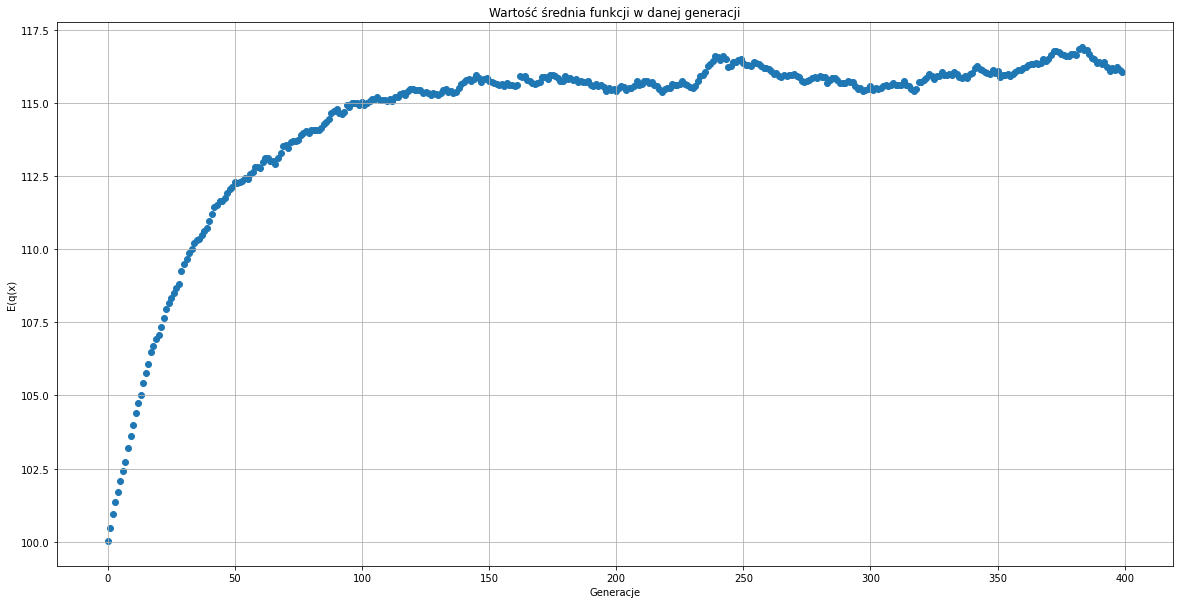

pm: 0.005, optimum: 150.8


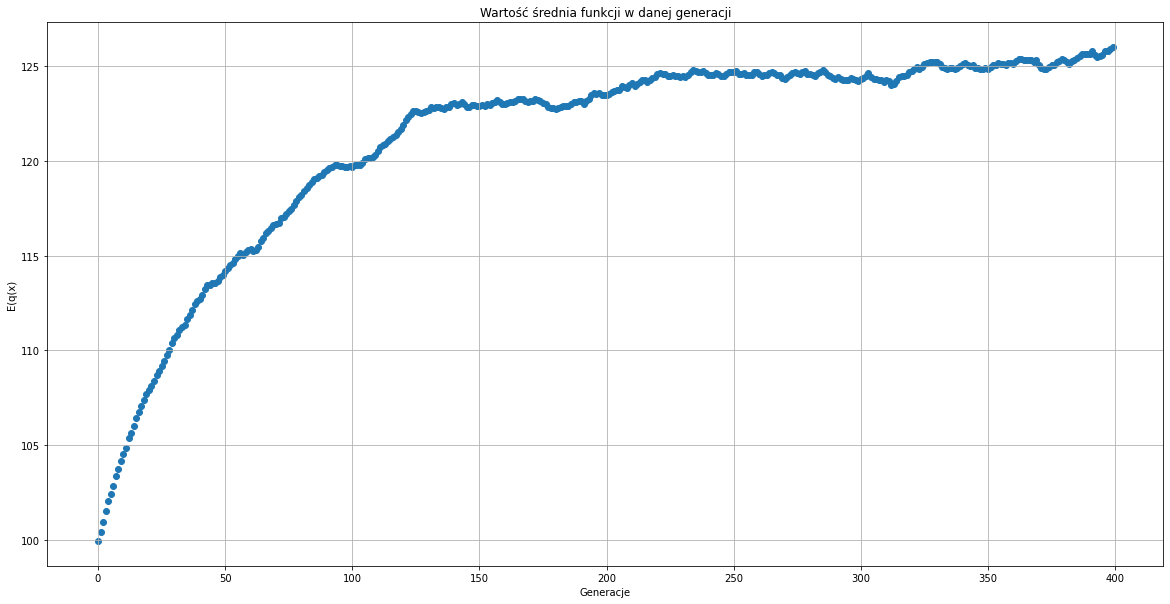

In [18]:
test("pm", p_mutations, 25)

Wraz ze spadkiem p_m możemy zaobserwować, że średnia wartość funkcji rośnie. Wydaje się to zgadzać z założeniem, że mała mutacja jest pożądana, jako mechanizm pomocniczy umożliwiający opuszczenie ekstremum lokalnego. Natomiast dla zbyt dużych wartości może zaburzać kształtwoanie się pożądanych cech.

# Badanie wpływu prawdopodobieństwa krzyżowania na działanie AG

Średnia z najlepszych wyników:
pc: 0.9, optimum: 134.64


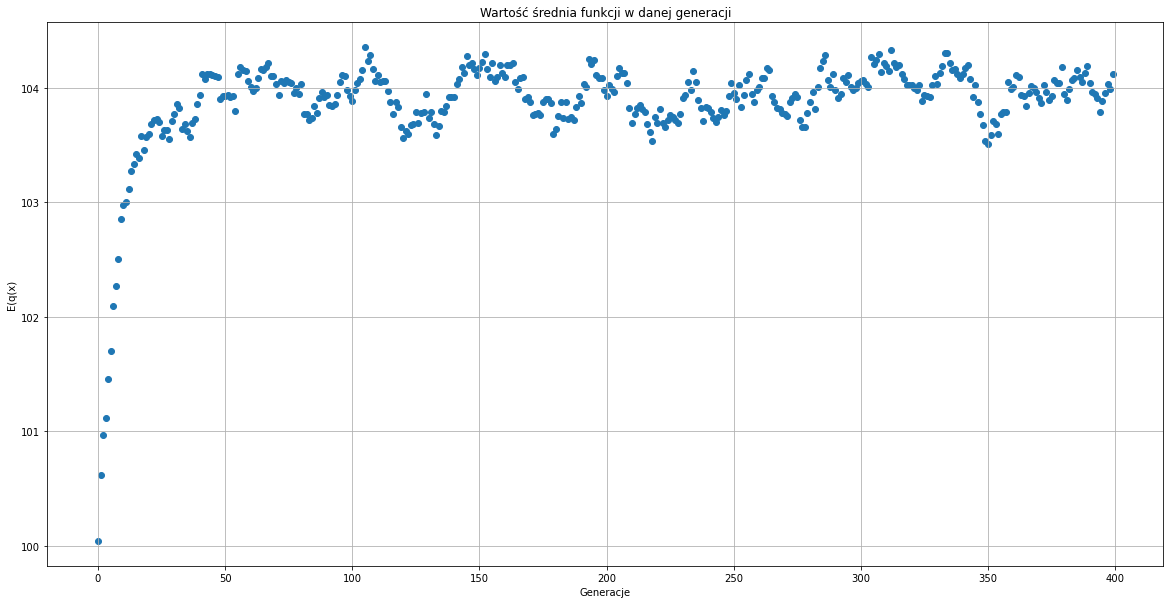

pc: 0.75, optimum: 134.28


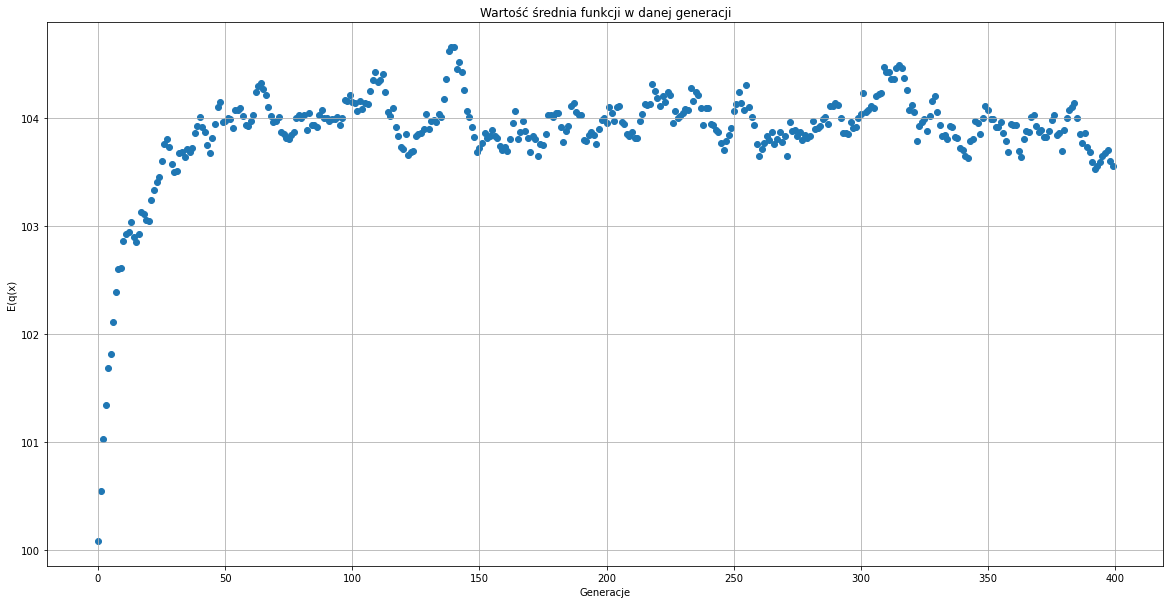

pc: 0.6, optimum: 134.48


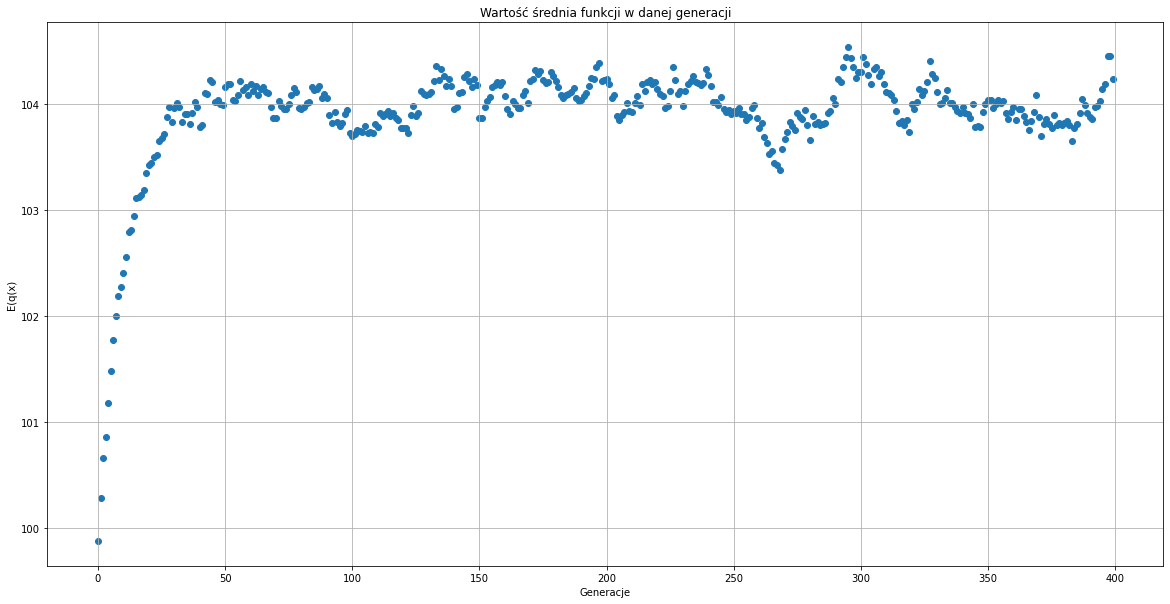

pc: 0.5, optimum: 134.48


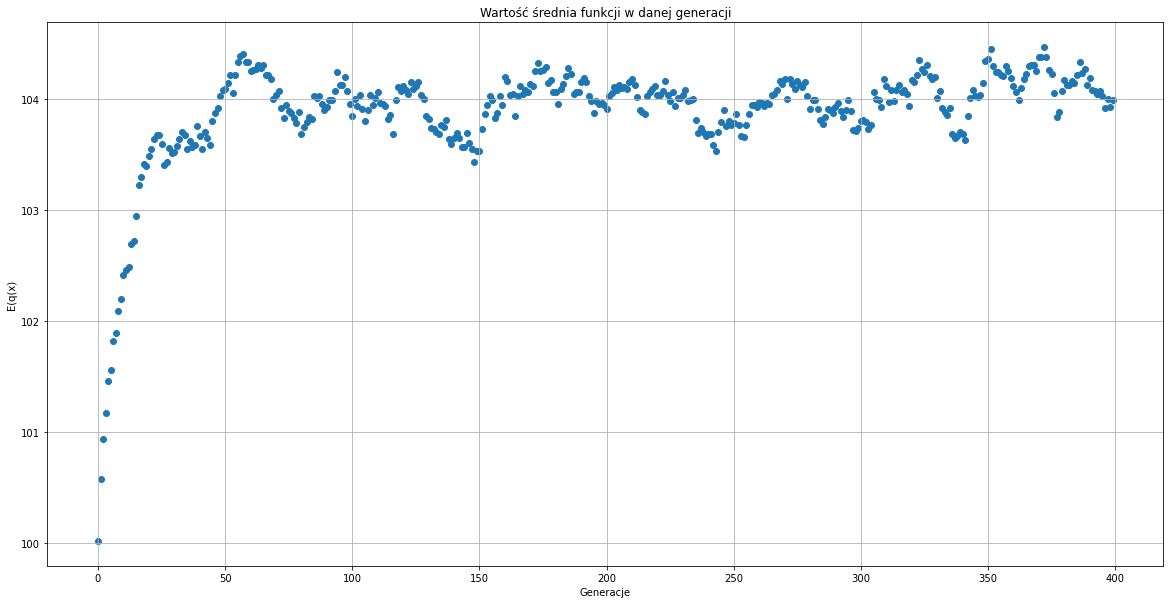

pc: 0.25, optimum: 134.0


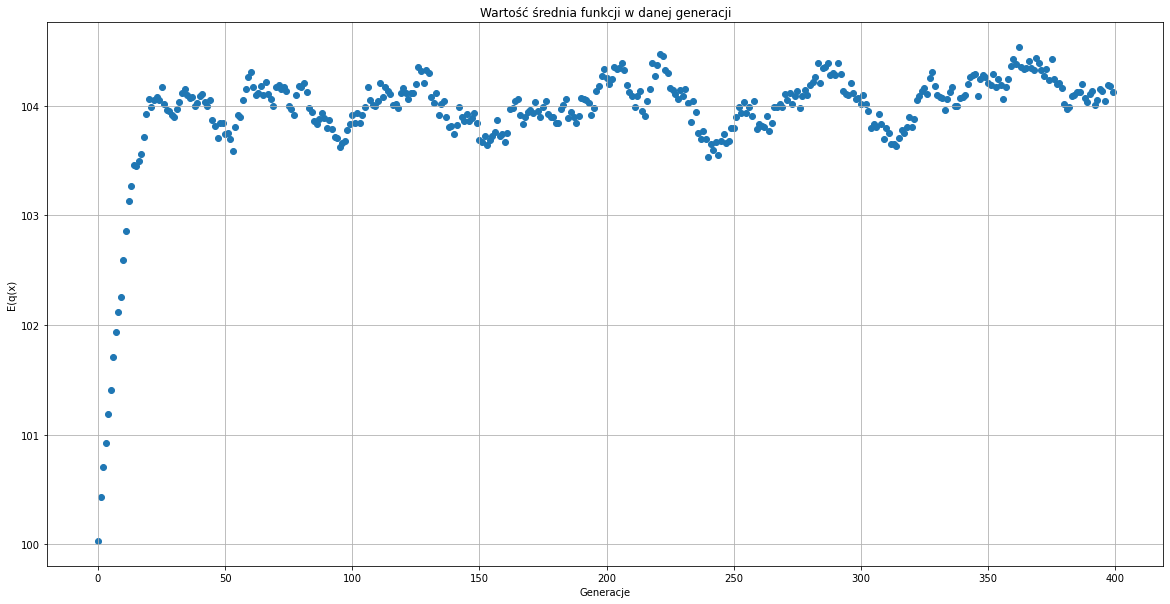

In [19]:
test("pc", p_crossovers, 25)

Zmiany parametru prawdopodobieństwa krzyżowania nie miały dużego wpływu na wartość funkcji dla podanych danych. Średnia funkcji osiągała 135 punktów. W naszym przypadku używamy krzyżowania jednopunktowego, które ogranicza nam przestrzeń przeszukiwań (nie wszystkie kombinacje genów są osiągalne), co może być powodem słabej możliwości optymalizacji w tym wypadku.

# Optymalne działanie dla wybranych parametrów

Analizując powyższe testy i dalej ręcznie dostrajając parametry w miarę optymalny wynik otrzymamy dla: population_size = 250, p_mutation = 0.0001, p_crossing = 0.95

In [20]:
example_result = genetic_algorithm(profit_function, 0.0001, 0.95, 250, total_budget)

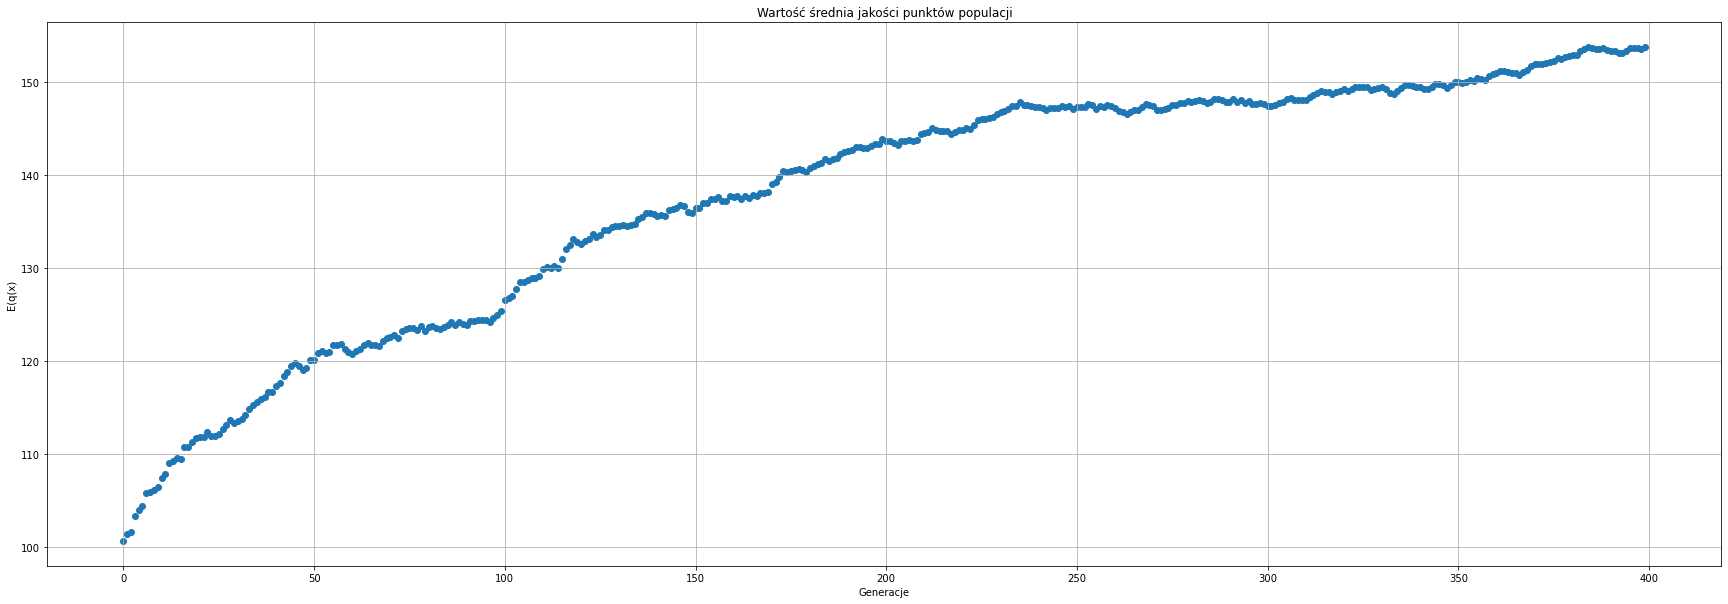

Najlepszy wynik: (162.0, array([1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.]))
Historia najlepszych osobników w każdej generacji: [120. 122. 122. 121. 125. 124. 126. 12

In [21]:
y = example_result[3]
x = np.arange(len(y))
plt.figure(figsize=(30, 10))
plt.scatter(x, y)
plt.title("Wartość średnia jakości punktów populacji")
plt.xlabel("Generacje")
plt.ylabel("E(q(x)")
plt.grid(b=True)
plt.show()
print(f"Najlepszy wynik: {example_result[0]}")
print(f"Historia najlepszych osobników w każdej generacji: {example_result[1]}")